In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt

# For handling structures and visualizing structures
from ase import Atoms
from ase.build import graphene_nanoribbon
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io import read, write

# For MD
from ase.calculators.tersoff import Tersoff
from ase.constraints import FixAtoms
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ase.neighborlist import neighbor_list

# Function for drawing atoms with atom indices and color depending MD constraint
def draw_atoms(atoms, radius=200, drawfixed=True):
    fig, ax = plt.subplots()

    # For drawing constraints
    if len(atoms.constraints) > 0:
        constraints = atoms.constraints[0].index
    else:
        constraints = []

    for ai, atom in enumerate(atoms):
        color = "k"
        if drawfixed and ai in constraints:
            color = "tab:red"
        ax.scatter(atom.position[2], atom.position[0], color=color, alpha=0.5, s=radius)
        ax.annotate(ai, (atom.position[2], atom.position[0]), ha="center", va="center", color="white")
    ax.set_xlim([0, atoms.cell[2,2]])
    ax.set_ylim([0, atoms.cell[0,0]])
    ax.set_xlabel("z, Å")
    ax.set_ylabel("x, Å")
    ax.axis("equal")
    return ax

# Function for loading and plotting temperature along MD trajectory
def plot_mdlog(fname="md.log"):
    log = np.loadtxt(fname, skiprows=1)
    fig, ax = plt.subplots()
    ax.plot(log[:,0], log[:, 4], color="k", alpha=0.5)
    ax.set_xlabel("Time, ps")
    ax.set_ylabel("Temperature, K")
    return ax

# Function for sorting if needed
def sort_atoms(atoms):
    pos = atoms.get_positions()
    sorted_indices = np.lexsort((pos[:, 0], pos[:, 1], pos[:, 2]))
    return atoms[sorted_indices]

### Hamiltonian in this project

Nearest neighbor tight-binding with on-site $\epsilon=0$ eV and hopping $t = t_0 (d_0/d)^2$, where $t_0=-2.7$ eV and $d_0$ is the equilibrium bond length and $d$ is the actual bond length between two orbitals.
With thermal vibrations in molecular dynamics, the $d$ is going to vary and therefore the hopping elements of the Hamiltonian.

### Create unit cell (here graphene nanoribbon)

Vary these parameters and plot bands/transmission:
* The type of ribbon "kind"
* Width of ribbon "n"

If you want to consider PBC and k-sampling, feel free to consider doing graphene (instead of nanoribbons). The graphene Hamiltonian is a little trickier due to the PBC, however, the molecular dynamics will be slightly easier for graphene since there are no free edges that we need to fix (more on that later).

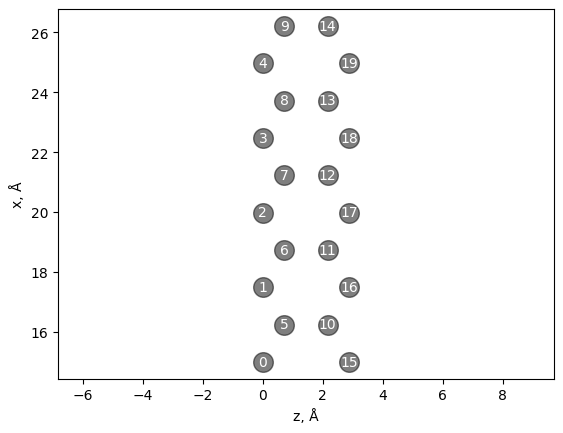

In [2]:
kind = "armchair"     # "armchair" or "zigzag"
n = 5                 # width parameter
length = 1            # periodic repetitions along z, i.e., transport direction here
vacuum = 15.0         # vacuum in non-periodic directions (Å)
bond = 1.43877067     # Optimized using C.tersoff potential discussed below
Vpppi = -2.7          # eV

ribbon = graphene_nanoribbon(n=n,
                             m=length,
                             type=kind,
                             C_C=bond,
                             vacuum=vacuum)
ribbon.pbc = True
ribbon = sort_atoms(ribbon)
draw_atoms(ribbon)

structure = ribbon

In [3]:
# view(ribbon)

### First study band structure and transmission in pristine/static system

#### Band structure

In [4]:
# Here calculate and plot the band structure for unit cell

def hamdd(xyz):
    #### Distance-dependent tight binding hamiltonian for a set of atomic coordinates in units of Vpppi
    cut = bond + 0.3 # only look up to this distance
    N = len(xyz)
    hamdd = np.zeros([N,N])
    dist = np.linalg.norm(xyz[None, :, :] - xyz[:, None, :], axis=2)
    for i in np.arange(N):
        for j in np.arange(N):
            if (i != j) & (dist[i,j] < cut):
                hamdd[i,j] = Vpppi*(bond/dist[i,j])**2  # if using distance dependence!
    return hamdd

def hamhop(xyz1,xyz2):
    #### The hopping/hamiltonian between the set of atoms with coordinates xyz1 and xyz2 (n1 x n2 matrix)
    n1 = len(xyz1)
    n2 = len(xyz2)
    xyz = np.concatenate((xyz1,xyz2)) ## combine coordinates to total
    htmp = hamdd(xyz)
    return htmp[0:n1,n1:n1+n2]

def get_ham_k(atoms, k_scaled, hamhop, Rmax=1, hermitize=True):
    """
    H(k) = sum_R H(R) exp(i 2π k·R)
    """
    xyz = atoms.get_positions()
    cell = atoms.cell.array
    pbc  = atoms.get_pbc()
    n    = len(xyz)

    # Integer translations R (only periodic directions)
    ranges = [range(-Rmax, Rmax+1) if p else [0] for p in pbc]
    R = np.array(np.meshgrid(*ranges, indexing="ij")).reshape(3, -1).T  # (nR,3)

    # Cartesian translations
    T = R @ cell  # (nR,3)

    # Hopping matrices H(R)
    # HR = np.stack([hamhop(xyz, xyz + Ti) for Ti in T], axis=0)  # (nR,n,n)
    
    # Handle R=0 (self-interaction) separately to avoid division by zero in hamhop
    HR_list = []
    for Ti in T:
        if np.linalg.norm(Ti) < 1e-5:
            HR_list.append(hamdd(xyz))
        else:
            HR_list.append(hamhop(xyz, xyz + Ti))
            
    HR = np.stack(HR_list, axis=0)  # (nR,n,n)

    # Phase factors and contraction
    phases = np.exp(1j * 2*np.pi * (R @ k_scaled))              # (nR,)
    Hk = np.tensordot(phases, HR, axes=(0, 0))                  # (n,n)
    if hermitize:
        Hk = 0.5 * (Hk + Hk.conj().T)
    return Hk

In [5]:
def plot_bandstructure(structure, kpoints=300):
    k_z = np.linspace(-0.5, 0.5, kpoints)
    energies = []
    
    for k in k_z:
        # Construct k-vector for Z-direction transport (index 2)
        k_scaled = np.array([0, 0, k])
        
        # Calculate Hamiltonian in k-space
        Hk = get_ham_k(structure, k_scaled, hamhop)
        
        # Diagonalize
        eigvals = np.linalg.eigvalsh(Hk)
        energies.append(eigvals)
        
    energies = np.array(energies)
    
    # Plotting
    plt.figure(figsize=(6, 5))
    plt.plot(k_z, energies, 'k-', alpha=0.6)
    plt.title("Bandstructure")
    plt.xlabel(r"$k_z$ ($2\pi/L_z$)")
    plt.ylabel("Energy (eV)")
    plt.xlim(-0.5, 0.5)
    plt.grid(True, alpha=0.3)
    plt.show()

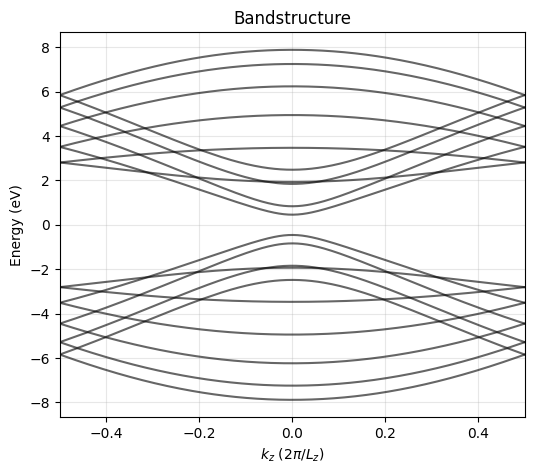

In [6]:
plot_bandstructure(structure)

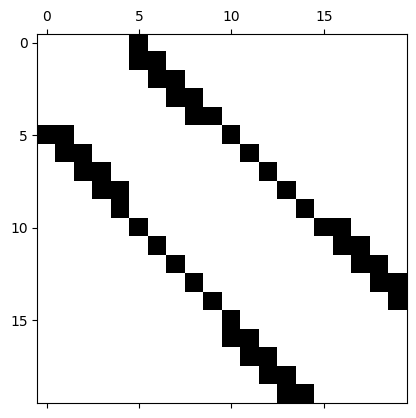

In [7]:
positions = structure.get_positions()
Hbig = hamdd(positions)
plt.spy(Hbig)

#### Transmission function (of pristine/static structure)

Number of atoms (and orbitals) in unit cell: 20


<Axes: xlabel='z, Å', ylabel='x, Å'>

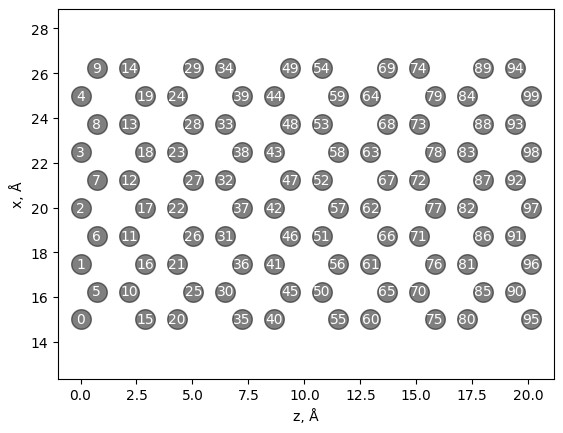

In [8]:
Ntransport = 5 # number of repetitions in transport direction (z). To create simple [L|L|C|R|R] geometry.
pristine_structure = structure.repeat((1, 1, Ntransport))

natom_elec = len(structure)
print("Number of atoms (and orbitals) in unit cell:", natom_elec)

draw_atoms(pristine_structure)

In [9]:
# Here calculate transmission function and relate back to the bands

In [10]:
positions = pristine_structure.get_positions()
Hbig = hamdd(positions)

In [11]:
def SplitHam(H, nL, nR):
    no = H.shape[0]
    nC = no - 2*nL - 2*nR
    nD = nL + nC + nR
    if nC < 1:
        print("Setup error: central region size =", nC)
        print("Use [L | L | C | R | R] setup")
        return
    
    # Boundaries
    b0 = 0
    b1 = nL
    b2 = 2*nL
    b3 = 2*nL + nC
    b4 = 2*nL + nC + nR
    b5 = no

    HL = H[b0:b1, b0:b1]    # Left lead onsite (L1)
    VL = H[b1:b2, b0:b1]    # L2 → L1 hopping

    VCL = H[b2:b3, b1:b2]   # C → L2
    VLC = VCL.T.conj()      # L2 → C

    HC = H[b2:b3, b2:b3]    # Central region
    VCR = H[b2:b3, b3:b4]   # C → R1
    VRC = VCR.T.conj()      # R1 → C

    VR = H[b3:b4, b4:b5]    # R1 → R2 hopping

    HR = H[b4:b5, b4:b5]    # Right lead onsite (R2)

    HD = H[b1:b4, b1:b4]    # Device block
    VLD = H[b1:b4, b0:b1]   # L1 → device
    VRD = H[b1:b4, b4:b5]   # device → R2

    # Return in left → right order
    return HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD

def plot_ham(nL, nR, Hbig):
    nC = Hbig.shape[0] - 2*nL - 2*nR
    b0 = 0
    b1 = nL
    b2 = 2*nL
    b3 = 2*nL + nC
    b4 = 2*nL + nC + nR
    b5 = Hbig.shape[0]

    plt.figure(figsize=(8,8))
    plt.spy(Hbig,extent=(0, Hbig.shape[0], Hbig.shape[0],0))
    # Draw block boundaries
    for b in [b1, b2, b3, b4]:
        plt.axhline(b, color='k', linewidth=1)
        plt.axvline(b, color='k', linewidth=1)

    # Add text labels
    plt.text((b0+b1)/2, (b0+b1)/2, "L1", ha='center', va='center', color='blue')

    plt.text((b1+b2)/2, (b1+b2)/2, "L2", ha='center', va='center', color='green')
    plt.text((b2+b3)/2, (b2+b3)/2, "C", ha='center', va='center', color='green')
    plt.text((b3+b4)/2, (b3+b4)/2, "R1", ha='center', va='center', color='green')
    plt.text((b4+b5)/2, (b4+b5)/2, "R2", ha='center', va='center', color='blue')

    plt.show()

def get_surface_greens_function(h_unit, v_unit, z, max_iter=100,tol=1e-10):
    h = np.array(h_unit, dtype=complex)
    v = np.array(v_unit, dtype=complex)
    v_dag = v.T.conj()
    dim = h.shape[0]
    I = np.eye(dim)
    
    eps_s, eps = h.copy(), h.copy()
    alpha, beta = v.copy(), v_dag.copy()
       
    for _ in range(max_iter):
        zI_eps = z * I - eps
        # Using solve for better numerical stability than direct inv
        g_alpha = np.linalg.solve(zI_eps, alpha)
        g_beta = np.linalg.solve(zI_eps, beta)
           
        alpha_next = alpha @ g_alpha
        beta_next = beta @ g_beta
        eps_next = eps + alpha @ g_beta + beta @ g_alpha
        eps_s_next = eps_s + alpha @ g_beta
           
        if np.linalg.norm(alpha_next, ord=np.inf) < tol:
            eps_s = eps_s_next
            break
        alpha, beta, eps, eps_s = alpha_next, beta_next, eps_next, eps_s_next

    g_s=np.linalg.inv(z * I - eps_s)
    g_b=np.linalg.inv(z * I - eps)
    sigma_s=eps_s-h.copy()
    sigma_b=eps-h.copy()

    return g_s,g_b,sigma_s,sigma_b

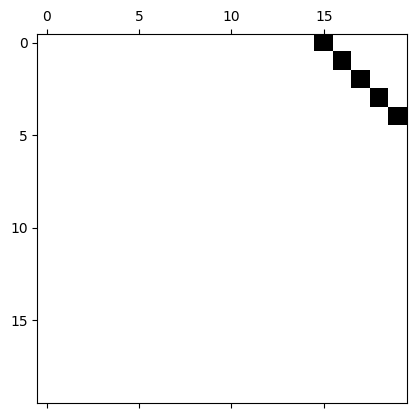

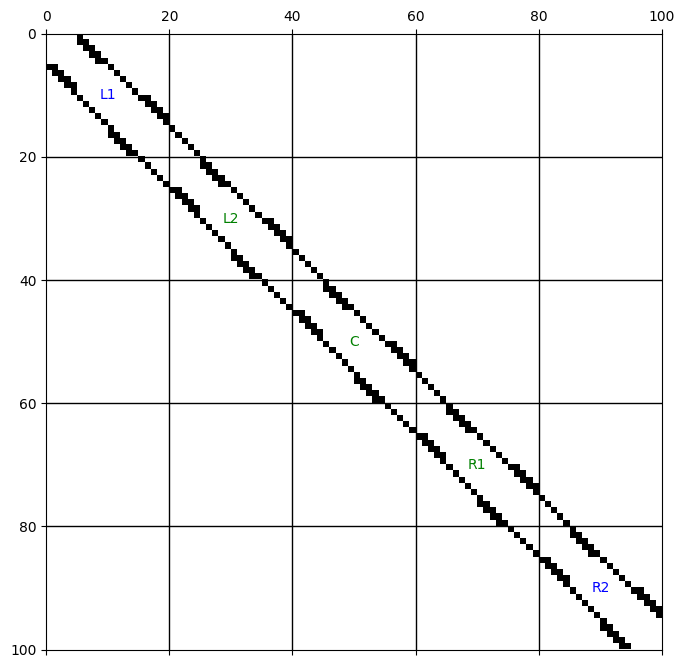

In [12]:
HL, VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD = SplitHam(Hbig, natom_elec, natom_elec)

plt.spy(VRC)

plot_ham(natom_elec, natom_elec, Hbig)

In [13]:
dim = HC.shape[0]
I = np.eye(dim, dtype=complex)

energy = np.linspace(-10,10,200)
transmission = np.zeros_like(energy)
for i, e in enumerate(energy):
    z = e + 1j*1e-8
    gl_s, gl_b, sigmal_s, sigmal_b = get_surface_greens_function(HL, VL, z)
    gr_s, gr_b, sigmar_s, sigmar_b = get_surface_greens_function(HR, VR, z)

    # left and right lead, eq 134
    sigma_L = VLC.T.conj() @ gl_s @ VLC
    sigma_R = VRC.T.conj() @ gr_s @ VRC

    # gammas, eq 136
    gamma_L = 1j * (sigma_L - sigma_L.T.conj())
    gamma_R = 1j * (sigma_R - sigma_R.T.conj())

    g_C = np.linalg.inv(z * I - HC - sigma_L - sigma_R)
    t_matrix = gamma_R @ g_C @ gamma_L @ g_C.T.conj()

    transmission[i] = np.trace(t_matrix).real

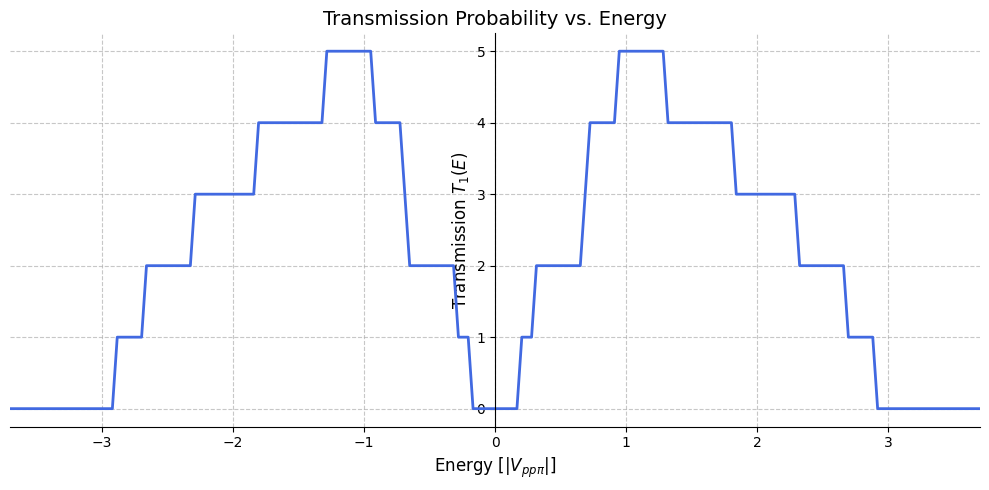

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Plot 1: Transmission 1
ax1.plot(energy / 2.7, transmission, color='royalblue', linewidth=2)
ax1.set_ylabel(r'Transmission $T_1(E)$', fontsize=12)
ax1.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
ax1.set_title('Transmission Probability vs. Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

# Move left y-axis spine to x = 0
ax1.spines['left'].set_position(('data', 0))
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

# Plot 2: Transmission 2
# ax2.plot(energy / 2.7, transmission2, color='crimson', linewidth=2)
# ax2.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
# ax2.set_ylabel(r'Transmission $T_2(E)$', fontsize=12)
# ax2.grid(True, linestyle='--', alpha=0.7)

# # Move left y-axis spine to x = 0
# ax2.spines['left'].set_position(('data', 0))
# ax2.spines['right'].set_color('none')
# ax2.spines['top'].set_color('none')

plt.xlim(energy.min()/2.7, energy.max()/2.7)
plt.tight_layout()
plt.show()

### Now move the atoms according to Newton's laws using molecular dynamics (MD)

```text
Create a file "C.tersoff" with the following contents:

# Tersoff parameters for carbon. Based on J. Tersoff, Phys. Rev. Lett. 61, 2879 (1988)
C C C 3 1 0.0 38049 4.3484 -0.93 0.72751 1.5724e-7 2.2119 430.0 1.95 0.15 3.4879 1393.6
```

In [15]:
# Load parameter file
calc = Tersoff.from_lammps("C.tersoff")

# Set up calculator
structure.calc = calc # Attach Tersoff calculator based on parameters in C.tersoff

# Now based on this interatomic potential, we can get total energies and forces:
energy = structure.get_potential_energy()
forces = structure.get_forces()

print(energy, "eV")
print(forces, "eV/Å")

-153.37831020173678 eV
[[ 2.94629247e+00  0.00000000e+00 -5.10372143e+00]
 [ 0.00000000e+00  0.00000000e+00  5.99616235e-15]
 [ 0.00000000e+00  0.00000000e+00  5.99616235e-15]
 [ 0.00000000e+00  0.00000000e+00  5.99616235e-15]
 [ 2.94680618e+00  0.00000000e+00 -2.63708103e+00]
 [-2.94680618e+00  0.00000000e+00  2.63708103e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.99611702e-15]
 [ 0.00000000e+00  0.00000000e+00 -5.99611702e-15]
 [ 0.00000000e+00  0.00000000e+00 -5.99611702e-15]
 [-2.94629247e+00  0.00000000e+00  5.10372143e+00]
 [-2.94680618e+00  0.00000000e+00 -2.63708103e+00]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [-2.94629247e+00  0.00000000e+00 -5.10372143e+00]
 [ 2.94629247e+00  0.00000000e+00  5.10372143e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.76996262e-15]
 [ 0.00000000e+00  0.00000000e+00 -9.76996262e-15]
 [ 0.00000000e+00  0.00000000e+00 -9.76996262e-15]
 [ 2.946

#### Create a MD structure with fixed electrode regions

<Axes: xlabel='z, Å', ylabel='x, Å'>

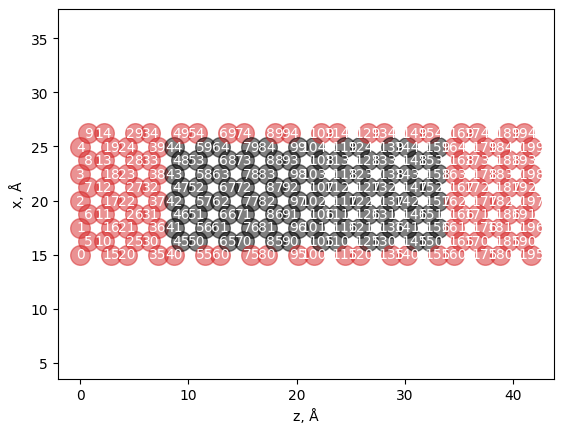

In [16]:
# First create longer [L|L|C|R|R] structure where L and R are fixed and the length of the central part (C) can be varied.
natoms_elec = len(structure)
xyz = structure.positions
lattice = structure.cell[:]
ntile = 10 # 
tiledir = 2 # tile in z
for n in range(1, ntile):
    xyz = np.concatenate((xyz, structure.positions + lattice[tiledir, :]*n))
tilemat = np.eye(3, dtype=int) # repetition matrix
tilemat[tiledir,tiledir] = ntile
lattice = tilemat @ lattice
natoms = len(xyz)
md_structure = Atoms(natoms*["C"], positions=xyz, cell=lattice, pbc=True) # Create a ASE atoms object of the repeated structure

# Fix electrode
fixed_uc = 2 # The number of electrode unit cells to fix on each side.
leftinds = list(range(0,natoms_elec*fixed_uc)) # Fix the two first unit cells
rightinds = list(range(natoms-natoms_elec*fixed_uc,natoms)) # Fix the two last unit cells

# ... and edges to simplify MD
cutoff = 1.5 # Nearest neighbor distance is d0 = 1.43877067 Å
bulk_nneighbors = 3 # In bulk graphene there are 3 nearest neighbors

i, j = neighbor_list("ij", md_structure, cutoff)
counts = np.bincount(i, minlength=len(md_structure))
edgeinds = list(np.where(counts < bulk_nneighbors)[0])

allinds = np.unique(leftinds+rightinds+edgeinds)
fixed = FixAtoms(mask=allinds)
md_structure.set_constraint(fixed) # Fix L and R electrode
draw_atoms(md_structure) # Red atoms are fixed, grey atoms are free to move

In [17]:
# view(md_structure)

#### Perform MD

In [18]:
md_structure.calc = calc

temp_K = 300.0
timestep = 1.0  # Length of timestep in fs
friction = 0.01 # Friction or collision rate in 1/fs
dump = 1        # Choose how often atomic structure is saved along MD trajectory
nsteps = 1000   # Number of steps

MaxwellBoltzmannDistribution(md_structure, temperature_K=temp_K) # Set random initial velocities
dyn = Langevin(md_structure, timestep*units.fs, temperature_K=temp_K, friction=friction/units.fs, logfile='md.log') # Will append to "md.log" so you might have to delete files inbetween
dyn.attach(lambda: write('md.xyz', md_structure, append=True), interval=dump) # Will append to "md.xyz"...

dyn.run(nsteps)

Check temperature along the trajectory. There will likely be a period of equilibration, where the structure is equilibrating to the requested temperature. Therefore, I recommend you to "skip" a certain number of frames when you do the transport calculatins.

<Axes: xlabel='Time, ps', ylabel='Temperature, K'>

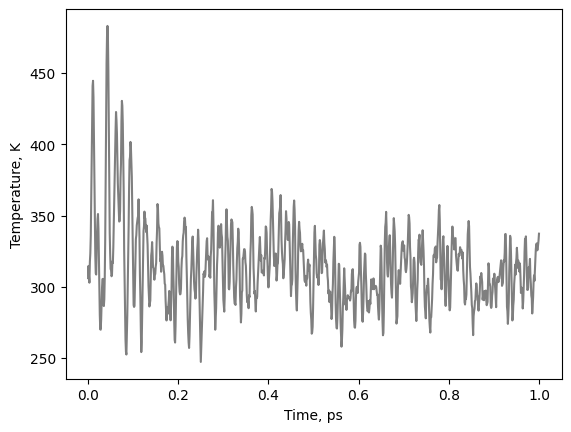

In [19]:
plot_mdlog()

In [20]:
md_traj = read("md.xyz", index=":") # Load trajectory from xyz

In [21]:
# Make sure the "correct" atoms are moving
view(md_traj)

<Popen: returncode: None args: ['c:\\Users\\Asger\\AppData\\Local\\Programs\...>

#### Calculate transmission function for snapshots

Tasks:
* Average the transmission function over trajectory and compare with "pristine" transmission calculated previously.
* Vary temperature and length of the MD region. How does the transport change? Plot and analyse how the resistance changes with MD region length. 

Tasks to do if time permits:
* Using the same MD trajectory, replace a C with N and calculate the transport properties with vibrations *and* a defect. A simple way of doing this is to change the on-site of one atom to $\epsilon \approx -2$ eV.
* Instead of averaging the transmission function over the trajectory, what happens if you average the Green's functions over time and from that effective Green's function you calculate one transmission function?

<Axes: xlabel='z, Å', ylabel='x, Å'>

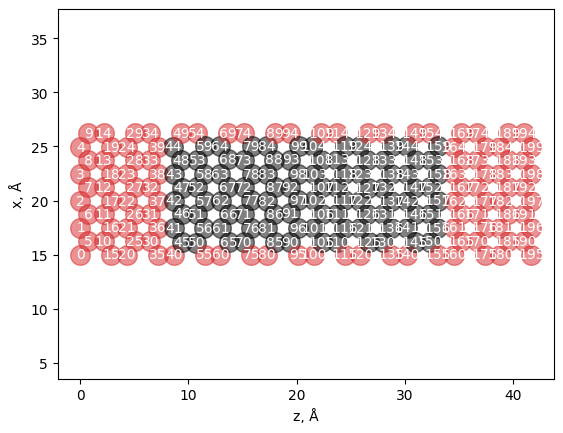

In [22]:
frame = md_traj[49] # To load e.g., 50th frame
draw_atoms(frame)

In [23]:
# Calculate transmission
def calculate_transmission(atoms, energy):
    positions = atoms.get_positions()
    Hbig = hamdd(positions)
    HL, VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD = SplitHam(Hbig, natom_elec, natom_elec)
    dim = HC.shape[0]
    I = np.eye(dim, dtype=complex)

    transmission = np.zeros_like(energy)
    for i, e in enumerate(energy):
        z = e + 1j*1e-8
        gl_s, gl_b, sigmal_s, sigmal_b = get_surface_greens_function(HL, VL, z)
        gr_s, gr_b, sigmar_s, sigmar_b = get_surface_greens_function(HR, VR, z)

        # left and right lead, eq 134
        sigma_L = VLC.T.conj() @ gl_s @ VLC
        sigma_R = VRC.T.conj() @ gr_s @ VRC

        # gammas, eq 136
        gamma_L = 1j * (sigma_L - sigma_L.T.conj())
        gamma_R = 1j * (sigma_R - sigma_R.T.conj())

        g_C = np.linalg.inv(z * I - HC - sigma_L - sigma_R)
        t_matrix = gamma_R @ g_C @ gamma_L @ g_C.T.conj()

        transmission[i] = np.trace(t_matrix).real
    return transmission



In [63]:
def precalculate_leads_greens_functions(atoms, energy):
    positions = atoms.get_positions()
    Hbig = hamdd(positions)
    HL, VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD = SplitHam(Hbig, natom_elec, natom_elec)
    
    n_energy = len(energy)
    sz = HL.shape[0]
    gl_s_list = np.zeros((n_energy, sz, sz), dtype=complex)
    gr_s_list = np.zeros((n_energy, sz, sz), dtype=complex)
    
    for i, e in enumerate(energy):
        z = e + 1j*1e-8
        gl_s, gl_b, sigmal_s, sigmal_b = get_surface_greens_function(HL, VL, z)
        gr_s, gr_b, sigmar_s, sigmar_b = get_surface_greens_function(HR, VR, z)
        gl_s_list[i] = gl_s
        gr_s_list[i] = gr_s
        
    return gl_s_list, gr_s_list

def calculate_transmission_fast(atoms, energy, gl_s_list, gr_s_list):
    positions = atoms.get_positions()
    Hbig = hamdd(positions)
    HL, VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD = SplitHam(Hbig, natom_elec, natom_elec)
    dim = HC.shape[0]
    I = np.eye(dim, dtype=complex)

    transmission = np.zeros_like(energy)
    for i, e in enumerate(energy):
        z = e + 1j*1e-8
        
        gl_s = gl_s_list[i]
        gr_s = gr_s_list[i]

        # left and right lead, eq 134
        sigma_L = VLC.T.conj() @ gl_s @ VLC
        sigma_R = VRC.T.conj() @ gr_s @ VRC

        # gammas, eq 136
        gamma_L = 1j * (sigma_L - sigma_L.T.conj())
        gamma_R = 1j * (sigma_R - sigma_R.T.conj())

        g_C = np.linalg.inv(z * I - HC - sigma_L - sigma_R)
        t_matrix = gamma_R @ g_C @ gamma_L @ g_C.T.conj()

        transmission[i] = np.trace(t_matrix).real
    return transmission

In [30]:
energy = np.linspace(-10,10,200)
transmission200 = calculate_transmission(md_traj[200], energy)

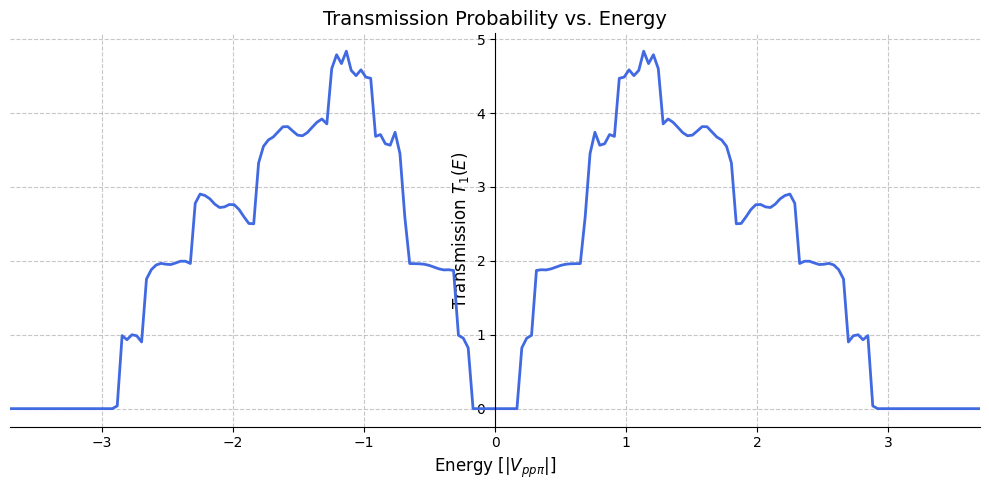

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Plot 1: Transmission 1
ax1.plot(energy / 2.7, transmission200, color='royalblue', linewidth=2)
ax1.set_ylabel(r'Transmission $T_1(E)$', fontsize=12)
ax1.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
ax1.set_title('Transmission Probability vs. Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

# Move left y-axis spine to x = 0
ax1.spines['left'].set_position(('data', 0))
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

# Plot 2: Transmission 2
# ax2.plot(energy / 2.7, transmission2, color='crimson', linewidth=2)
# ax2.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
# ax2.set_ylabel(r'Transmission $T_2(E)$', fontsize=12)
# ax2.grid(True, linestyle='--', alpha=0.7)

# # Move left y-axis spine to x = 0
# ax2.spines['left'].set_position(('data', 0))
# ax2.spines['right'].set_color('none')
# ax2.spines['top'].set_color('none')

plt.xlim(energy.min()/2.7, energy.max()/2.7)
plt.tight_layout()
plt.show()

In [ ]:
times = np.linspace(200, nsteps, 400, dtype=int) # Select frames from 200 (201) to nsteps
print(times)
energy = np.linspace(-10,10,200)

# Precalculate Green's functions for leads
print("Pre-calculating lead Green's functions...")
gl_s_list, gr_s_list = precalculate_leads_greens_functions(md_structure, energy)

transmissions2 = []
for t in times:
    print(t)
    frame = md_traj[t]
    T = calculate_transmission_fast(frame, energy, gl_s_list, gr_s_list)
    transmissions2.append(T)

[ 200  202  204  206  208  210  212  214  216  218  220  222  224  226
  228  230  232  234  236  238  240  242  244  246  248  250  252  254
  256  258  260  262  264  266  268  270  272  274  276  278  280  282
  284  286  288  290  292  294  296  298  300  302  304  306  308  310
  312  314  316  318  320  322  324  326  328  330  332  334  336  338
  340  342  344  346  348  350  352  354  356  358  360  362  364  366
  368  370  372  374  376  378  380  382  384  386  388  390  392  394
  396  398  400  402  404  406  408  410  412  414  416  418  420  422
  424  426  428  430  432  434  436  438  440  442  444  446  448  450
  452  454  456  458  460  462  464  466  468  470  472  474  476  478
  480  482  484  486  488  490  492  494  496  498  500  502  504  506
  508  510  512  514  516  518  520  522  524  526  528  530  532  534
  536  538  540  542  544  546  548  550  552  554  556  558  560  562
  564  566  568  570  572  574  576  578  580  582  584  586  588  590
  592 

In [66]:
transmission_avg2 = np.mean(transmissions2, axis=0)

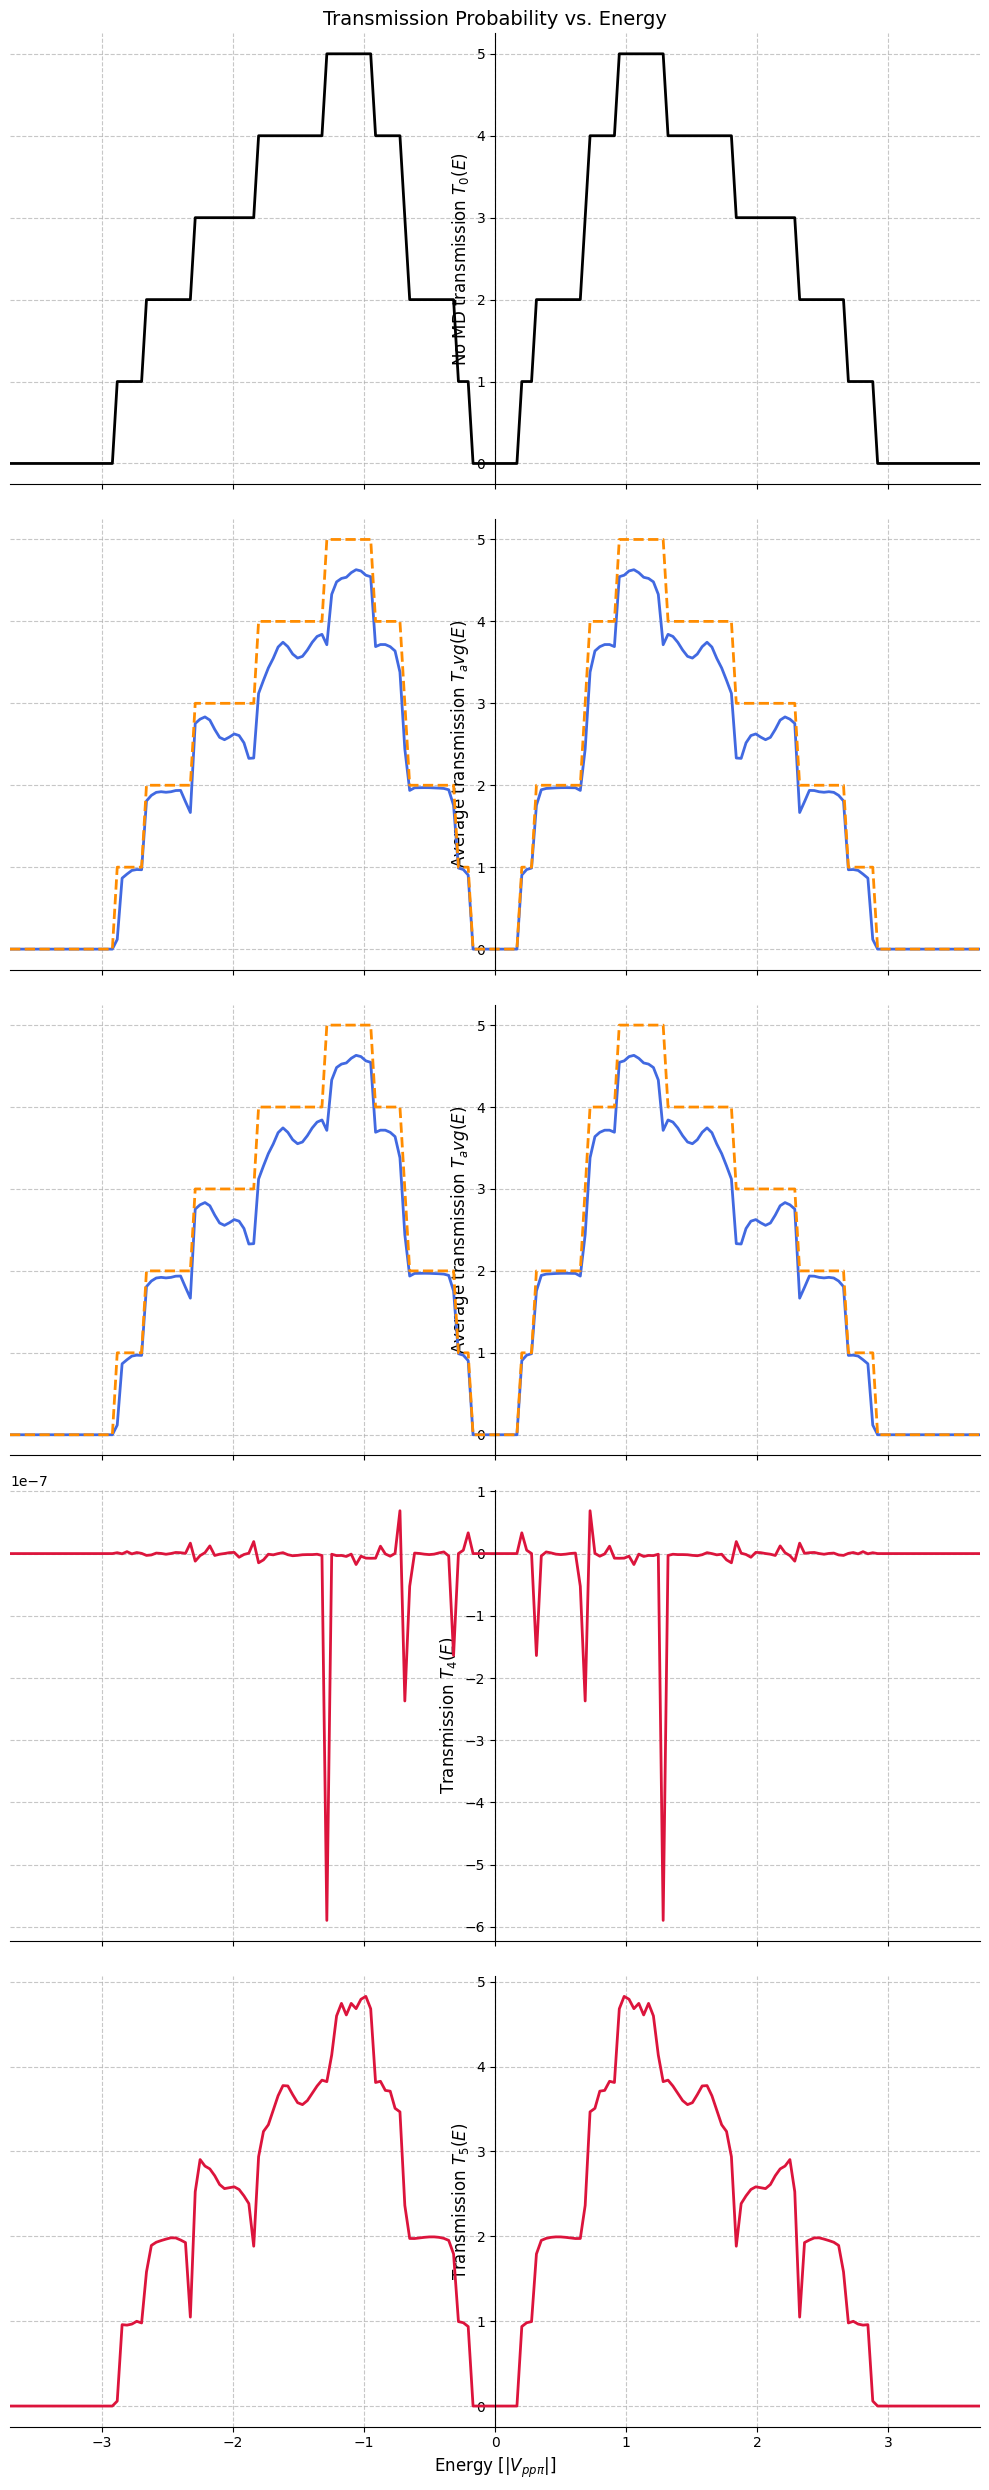

In [69]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 25), sharex=True)

# Plot 1: Transmission 1
ax1.plot(energy / 2.7, transmission, color='black', linewidth=2)
ax1.set_ylabel(r'No MD transmission $T_0(E)$', fontsize=12)
ax1.set_title('Transmission Probability vs. Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

# Move left y-axis spine to x = 0
ax1.spines['left'].set_position(('data', 0))
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

# Plot 2: Transmission 2
ax2.plot(energy / 2.7, transmission_avg, color='royalblue', linewidth=2)
ax2.plot(energy / 2.7, transmission, color='darkorange', linewidth=2, linestyle='--', alpha=1)
# ax2.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
ax2.set_ylabel(r'Average transmission $T_avg(E)$', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# Move left y-axis spine to x = 0
ax2.spines['left'].set_position(('data', 0))
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

# Plot 3: Transmission 3
ax3.plot(energy / 2.7, transmission_avg2, color='royalblue', linewidth=2)
ax3.plot(energy / 2.7, transmission, color='darkorange', linewidth=2, linestyle='--', alpha=1)
# ax2.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
ax3.set_ylabel(r'Average transmission $T_avg(E)$', fontsize=12)
ax3.grid(True, linestyle='--', alpha=0.7)

# Move left y-axis spine to x = 0
ax3.spines['left'].set_position(('data', 0))
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')


# Plot 4: Transmission 4
ax4.plot(energy / 2.7, transmission_avg2 - transmission_avg, color='crimson', linewidth=2)
# ax4.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
ax4.set_ylabel(r'Transmission $T_4(E)$', fontsize=12)
ax4.grid(True, linestyle='--', alpha=0.7)

# Move left y-axis spine to x = 0
ax4.spines['left'].set_position(('data', 0))
ax4.spines['right'].set_color('none')
ax4.spines['top'].set_color('none')

# Plot 5: Transmission 5
ax5.plot(energy / 2.7, transmissions[30], color='crimson', linewidth=2)
ax5.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
ax5.set_ylabel(r'Transmission $T_5(E)$', fontsize=12)
ax5.grid(True, linestyle='--', alpha=0.7)

# Move left y-axis spine to x = 0
ax5.spines['left'].set_position(('data', 0))
ax5.spines['right'].set_color('none')
ax5.spines['top'].set_color('none')

plt.xlim(energy.min()/2.7, energy.max()/2.7)
plt.tight_layout()
plt.show()